# Heart Disease Statistics Assignment 2
## Author: Nicholas Tam
## Group: 4

## 2. Preliminary Results

### 2.1. Loading relevant libraries

In [1]:
# Imports

# install.packages("infer") # Install infer package for use

library(dplyr) # Data manipulation operations
library(gridExtra) # Extensions for grid system
library(tidyverse) # Better presentation of data
library(repr) # String and binary representations of objects for several formats / mime types 
library(lubridate) # Easier date organisation
library(infer) # Bootstrap distribution, confidence interval
library(broom) # Reorganises outputs into tidy tibbles
library(ggplot2) # Provides commands to create complex plots
library(GGally) # Provides correlation between variables
library(AER) # Applied econometrics, including VIF


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.3     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: ca

### 2.2. Uploading and merging relevant tables

- Each data set is read separately, then merged into a single dataframe called `total_heart`, as shown in Table 1. 
- Before merging, the `location` column is created, to indicate the differing clinics that the probability model was applied to, including the clinic the model was derived from; the reference level is set to "Cleveland".
- The `age`, `sex`, `cp`, `trestbps`, `chol`, `thalach`, and `num` columns require a change in data type to be able to be used as intended.
- Due to several datasets either missing most or all of the data for `fbs`, `oldpeak`, `slope`, `ca` and `thal` columns, the columns have been removed under the assumption that they are irrelevant.
- The Switzerland dataset is missing data for `chol` and as such has been removed.
- Any values of `num` greater than 0 lead to the same result, and as such have been replaced by 1.

In [22]:
Cleveland_heart <- read.csv("https://raw.githubusercontent.com/Nick-2003/STAT-301-Group_4-Project/main/heart%2Bdisease%2BModified/processed_Cleveland.csv") %>% 
    mutate(location = "Cleveland")
Hungary_heart <- read.csv("https://raw.githubusercontent.com/Nick-2003/STAT-301-Group_4-Project/main/heart%2Bdisease%2BModified/processed_Hungarian.csv") %>% 
    mutate(location = "Hungary")
Switzerland_heart <- read.csv("https://raw.githubusercontent.com/Nick-2003/STAT-301-Group_4-Project/main/heart%2Bdisease%2BModified/processed_Switzerland.csv") %>% 
    mutate(location = "Switzerland")
California_heart <- read.csv("https://raw.githubusercontent.com/Nick-2003/STAT-301-Group_4-Project/main/heart%2Bdisease%2BModified/processed_VA.csv") %>% 
    mutate(location = "California")
total_heart <- rbind(Cleveland_heart, Hungary_heart, Switzerland_heart, California_heart) %>% 
    select(location, age, sex, cp, trestbps, chol, restecg, thalach, exang, num) %>% 
    filter(!(location == '?' | age == '?' | sex == '?' | cp == '?' | trestbps == '?' | trestbps == '0' | chol == '?' | chol == '0' | restecg == '?' | thalach == '?' | num == '?')) %>% 
    mutate(num = ifelse(num > 1, 1, num))  %>% 
    transform(sex = as.character(as.factor(sex)), cp = as.character(as.factor(cp)), trestbps = as.double(as.factor(trestbps)), chol = as.double(as.factor(chol)), thalach = as.double(as.factor(thalach)), num = as.character(as.factor(num))) 
# %>% 
total_heart$location <- factor(total_heart$location) %>% 
    relevel(total_heart$location, ref = "Cleveland")

head(total_heart)
# tail(total_heart)

location  age sex cp trestbps chol restecg thalach exang num
1 Cleveland 63  1   1  34        81  2       48      0     0  
2 Cleveland 67  1   4  43       134  2        6      1     1  
3 Cleveland 67  1   4  16        77  2       27      1     1  
4 Cleveland 37  1   3  25        98  0       84      0     0  
5 Cleveland 41  0   2  25        52  2       70      0     0  
6 Cleveland 56  1   2  16        84  0       76      0     0

_Table 1: Initial dataset for all required data_

### 2.3. Exploratory Data Analysis

#### 2.3.1. Distribution of cholesterol levels
- Histograms have been selected to display the sampling distribution of cholesterol levels and ages in each location, to allow easier observation of spread and centre of data.
- The majority of the `chol` distributions are skewed to the left.
- The majority of the `age` distributions are skewed to the right.

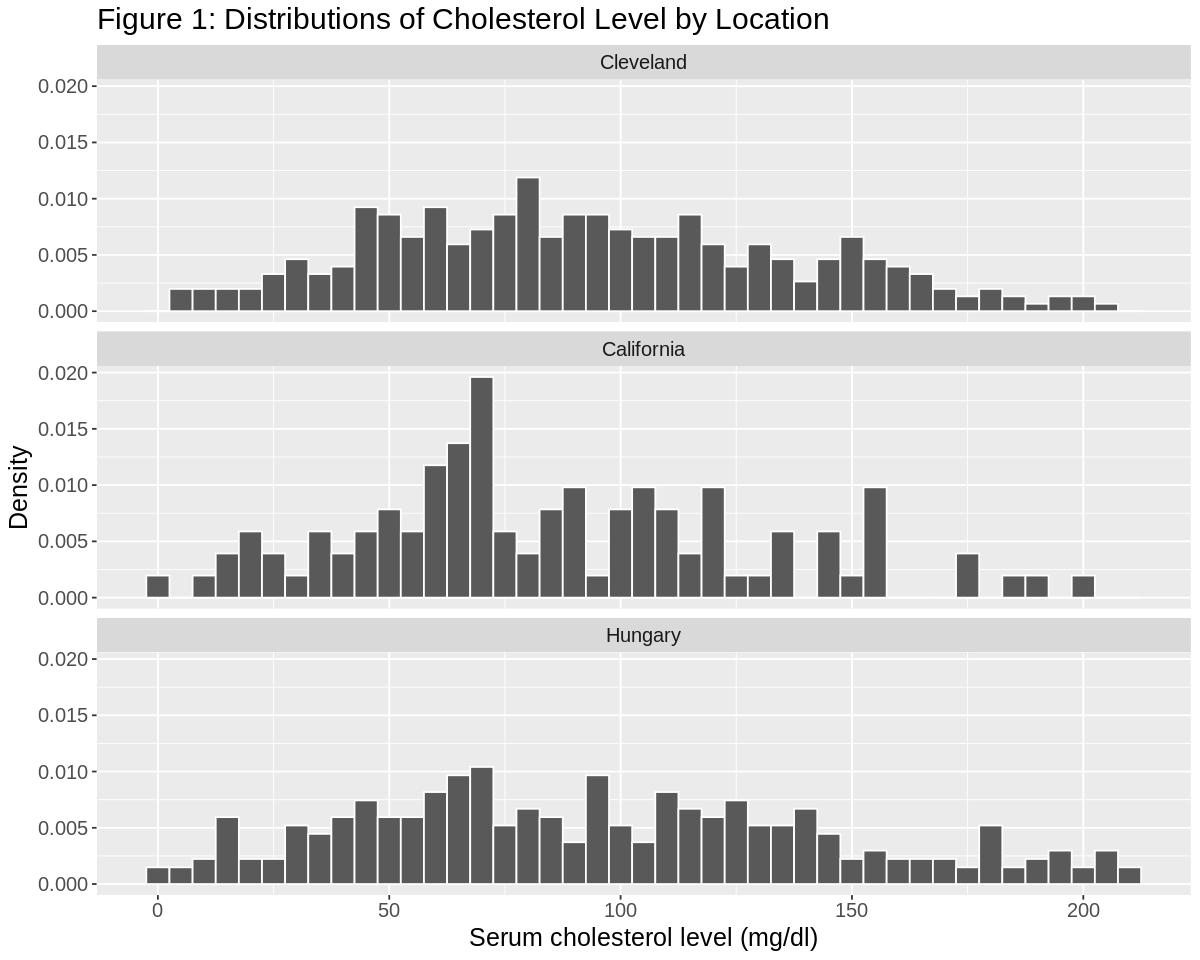

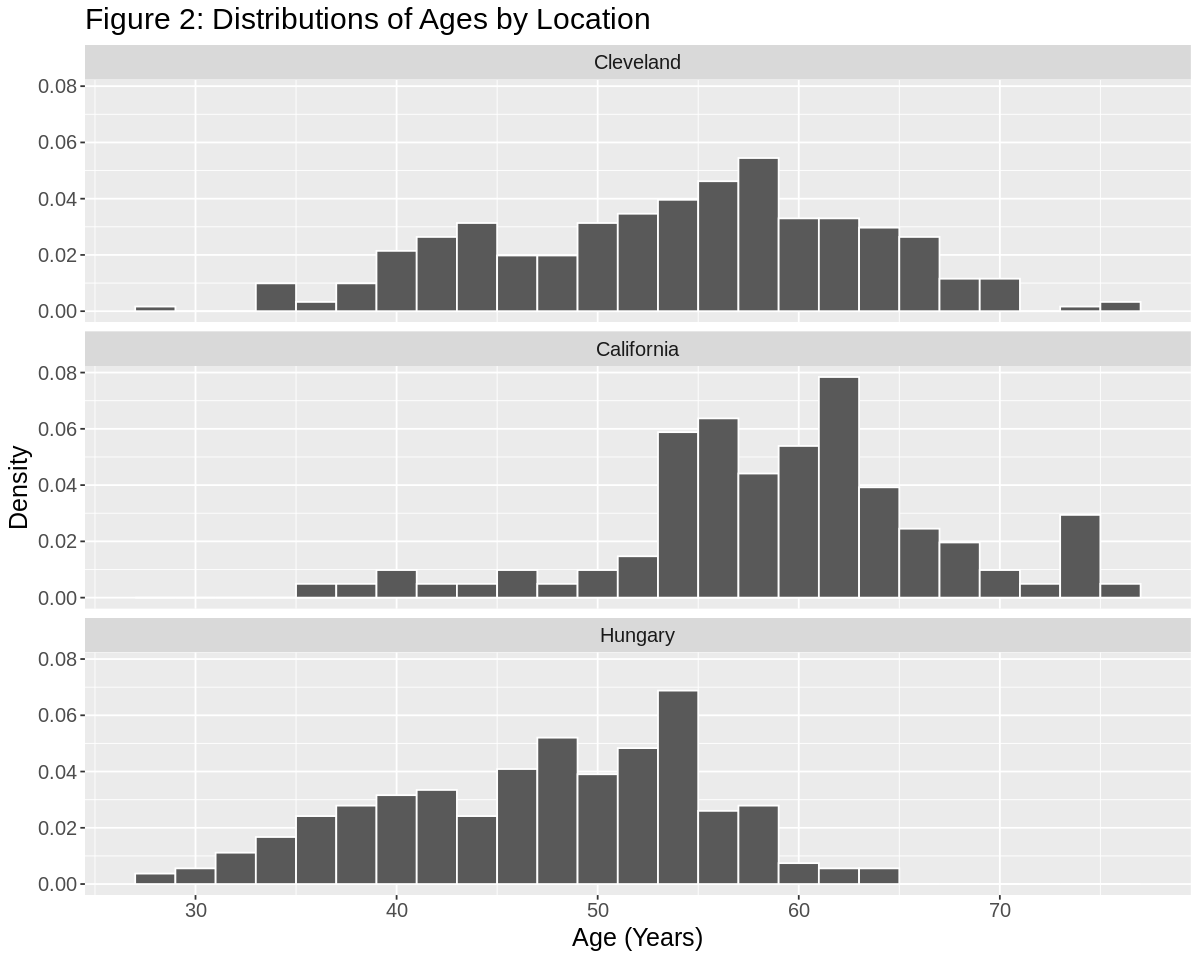

In [16]:
options(repr.plot.width = 10, repr.plot.height = 8)

# Distribution of cholesterol levels in each location 
dist_total_chol <- total_heart %>% 
    ggplot() + 
    geom_histogram(aes(x = chol, y = ..density..), color = 'white', binwidth = 5) +
    labs(x = "Serum cholesterol level (mg/dl)", y = "Density") + 
    facet_wrap(~location, scales = "fixed", nrow = 5) +
    ggtitle("Figure 1: Distributions of Cholesterol Level by Location") + 
    theme(text = element_text(size = 15)) 
dist_total_chol

# Distribution of age in each location 
dist_total_age <- total_heart %>% 
    # filter(sex == 1) %>% 
    ggplot() + 
    geom_histogram(aes(x = age, y = ..density..), color = 'white', binwidth = 2) +
    labs(x = "Age (Years)", y = "Density") + 
    facet_wrap(~location, scales = "fixed", nrow = 5) +
    ggtitle("Figure 2: Distributions of Ages by Location") + 
    theme(text = element_text(size = 15)) 
dist_total_age

#### 2.3.2. Boxplots of continuous variables
- Boxplots are used to illustrate the distribution and spread of cholesterol levels and ages in each location.
- The ranges and means of `chol` in each location are relatively similar.
- The median `chol` for California is slightly lower compared to the other locations.
- The mean and median `age` for each location apper to be significantly different from each other.

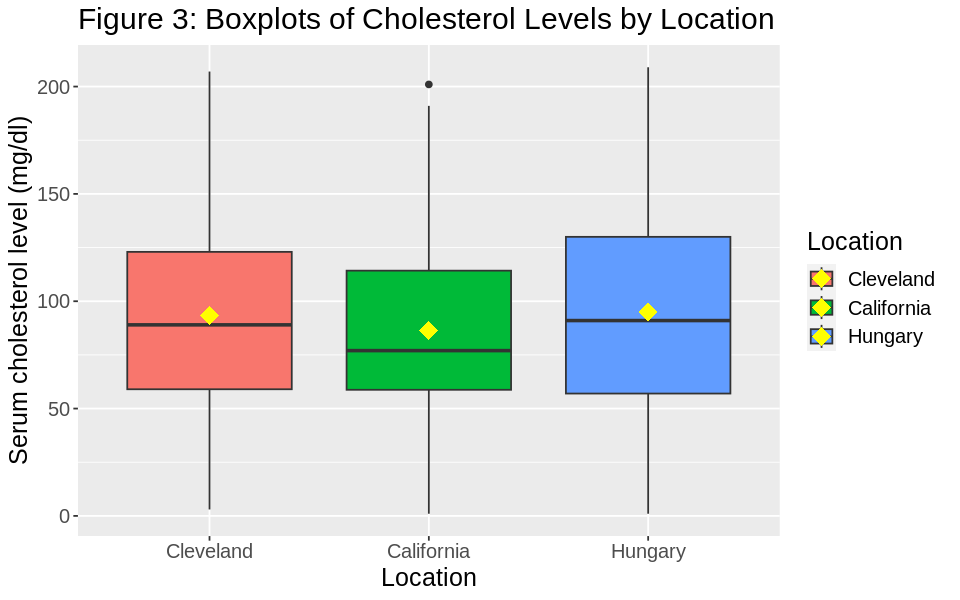

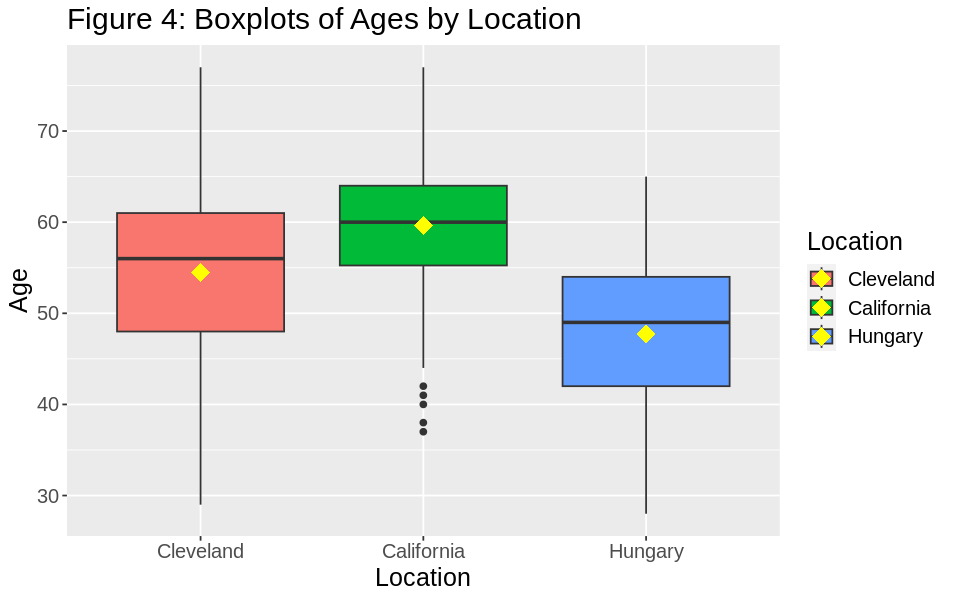

In [17]:
options(repr.plot.width = 8, repr.plot.height = 5)

# Boxplots of Cholesterol Levels by Location
box_total <- total_heart %>% 
    ggplot(aes(x = location, y = chol, fill = location)) + 
    geom_boxplot() + 
    labs(x = "Location", y = "Serum cholesterol level (mg/dl)", fill = "Location") + 
    ggtitle("Figure 3: Boxplots of Cholesterol Levels by Location") +
    theme(text = element_text(size = 15)) + 
    stat_summary(aes(location, chol, fill = location),
        fun = "mean", colour = "yellow", geom = "point",
        shape = 18, size = 5
    )
box_total

# Boxplots of Ages by Location
box_total <- total_heart %>% 
    ggplot(aes(x = location, y = age, fill = location)) + 
    geom_boxplot() + 
    labs(x = "Location", y = "Age", fill = "Location") + 
    ggtitle("Figure 4: Boxplots of Ages by Location") + 
    theme(text = element_text(size = 15)) + 
    stat_summary(aes(location, age, fill = location),
        fun = "mean", colour = "yellow", geom = "point",
        shape = 18, size = 5
    )
box_total

#### 2.3.3. Bar plots of average cholesterol level against age ranges
- Bar plot is used to give an idea of how `age` would affect average `chol`.
- Average `chol` are significantly lower for people of `age` less than 30, and relatively similar for people with `age` of 30 or above.

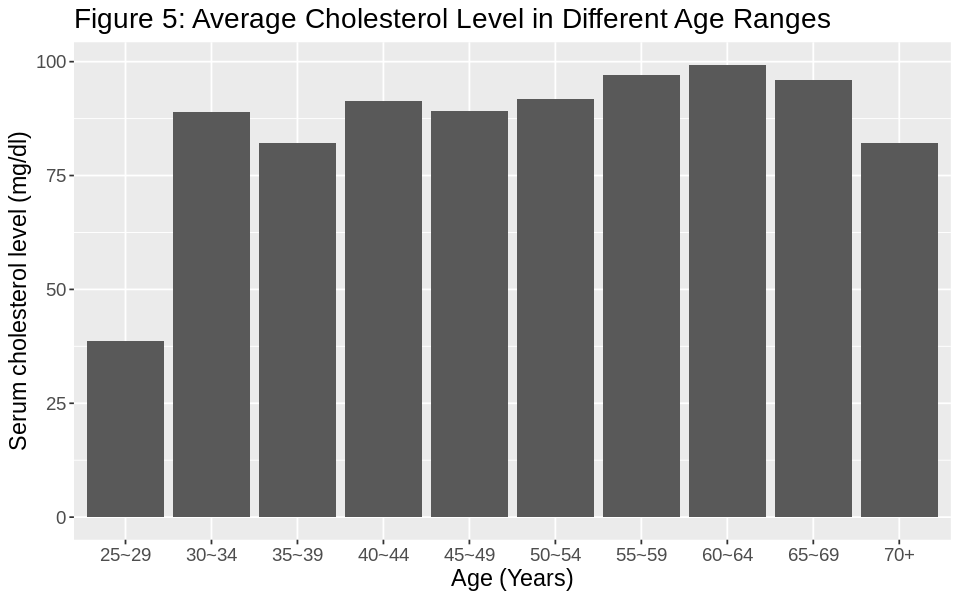

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5)
heart.dat <- total_heart %>%
    group_by(age) %>%
    summarize(chol = mean(chol, na.rm=TRUE))
# heart.dat

heart.col2 <- heart.dat %>%
    filter(age >= 25,age < 30) %>%
    select(chol)
col.val2 <- sum(heart.col2)/nrow(heart.col2)
heart.col3 <- heart.dat %>%
    filter(age >= 30,age < 35) %>%
    select(chol)
col.val3 <- sum(heart.col3)/nrow(heart.col3)
heart.col4 <- heart.dat %>%
    filter(age >= 35,age < 40) %>%
    select(chol)
col.val4 <- sum(heart.col4)/nrow(heart.col4)
heart.col5 <- heart.dat %>%
    filter(age >= 40,age < 45) %>%
    select(chol)
col.val5 <- sum(heart.col5)/nrow(heart.col5)
heart.col6 <- heart.dat %>%
    filter(age >= 45,age < 50) %>%
    select(chol)
col.val6 <- sum(heart.col6)/nrow(heart.col6)
heart.col7 <- heart.dat %>%
    filter(age >= 50,age < 55) %>%
    select(chol)
col.val7 <- sum(heart.col7)/nrow(heart.col7)
heart.col8 <- heart.dat %>%
    filter(age >= 55,age < 60) %>%
    select(chol)
col.val8 <- sum(heart.col8)/nrow(heart.col8)
heart.col9 <- heart.dat %>%
    filter(age >= 60,age < 65) %>%
    select(chol)
col.val9 <- sum(heart.col9)/nrow(heart.col9)
heart.col10 <- heart.dat %>%
    filter(age >= 65,age < 70) %>%
    select(chol)
col.val10 <- sum(heart.col10)/nrow(heart.col10)
heart.col11 <- heart.dat %>%
    filter(age >= 70) %>%
    select(chol)
col.val11 <- sum(heart.col11)/nrow(heart.col11)
heart.name <- c("25~29","30~34","35~39","40~44","45~49","50~54","55~59","60~64","65~69","70+")
heart.plot.data <- data.frame(heart.name,c(col.val2,col.val3,col.val4,col.val5,col.val6,col.val7,col.val8,col.val9,col.val10,col.val11))
colnames(heart.plot.data) <- c("heart.range","chol.avg")

age_chol_bar_plot <- ggplot(heart.plot.data, aes(x = heart.range, y = chol.avg)) +
    geom_bar(stat="identity") +
    ggtitle("Figure 5: Average Cholesterol Level in Different Age Ranges") +
    labs(x = "Age (Years)",y = "Serum cholesterol level (mg/dl)") + 
    # facet_wrap(~location, scales = "fixed", nrow = 3) +
    theme(text = element_text(size = 14))
age_chol_bar_plot

#### 2.3.4. Pair plots of all continous variables
- The correlations between all continuous variables are not particularly large, with the greatest correlation coefficient being between `age` and `trestbps` at 0.231.
- The correlations of `chol` with the other continous variables are not particularly high.

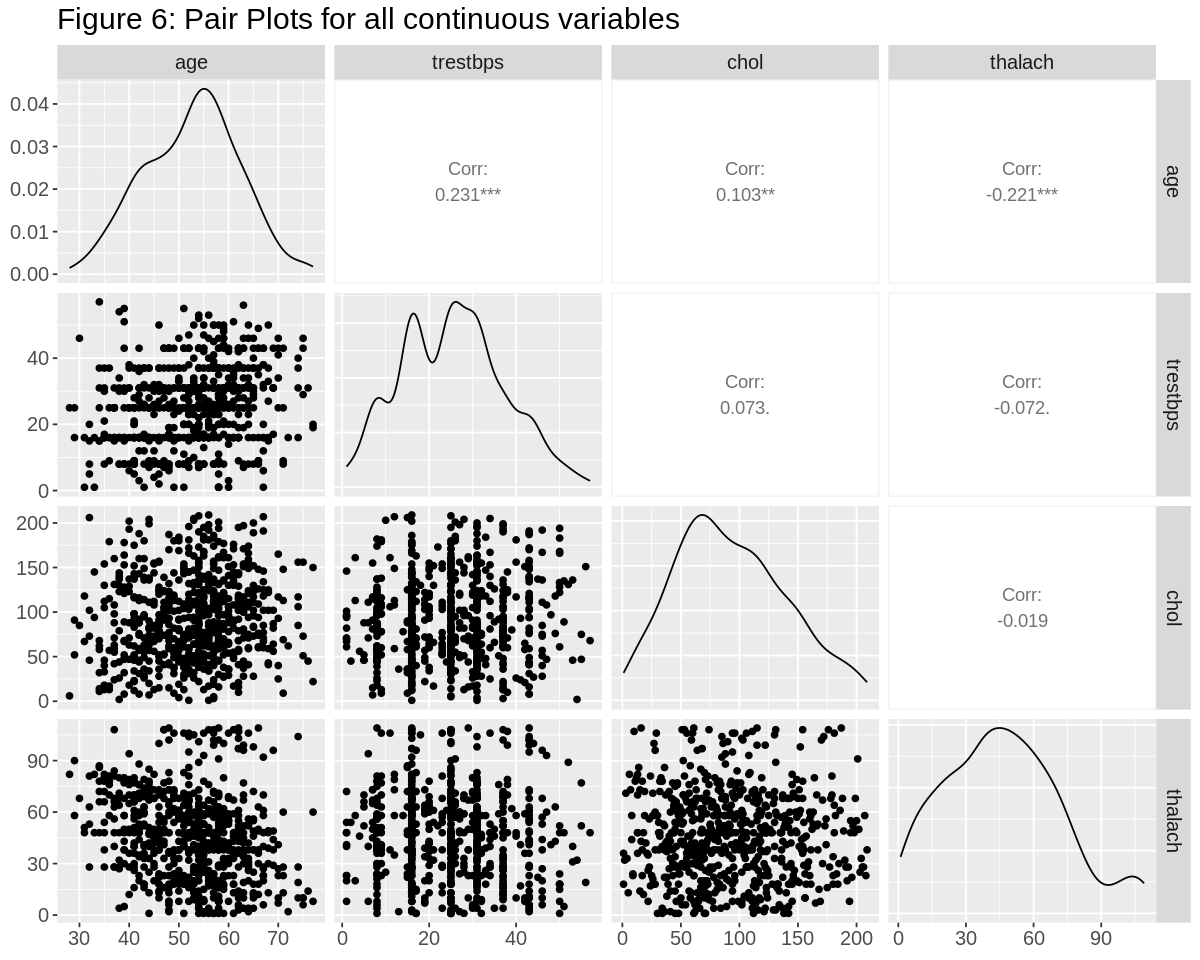

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)

heart_pair_plots <- total_heart %>%
  select(age, trestbps, chol, thalach) %>% 
  ggpairs(progress = FALSE) +
    ggtitle("Figure 6: Pair Plots for all continuous variables") +
  theme(
    text = element_text(size = 15),
    # plot.title = element_text(face = "bold"),
    # axis.title = element_text(face = "bold")
  )
heart_pair_plots

#### 2.3.5. Variance Inflation Factor (VIF) on categorical variables
- VIF applied for categorical variables to test for multicollinearity.
- VIF of all variables are not particularly large, so multicollinearity between all variables is relatively low.

In [20]:
total_heart <- total_heart %>% 
    select(location, age, sex, cp, trestbps, chol, restecg, thalach, exang, num)  
heart_MLR_add_inter_VIF <- vif(lm(chol ~ ., data = total_heart)) 
heart_MLR_add_inter_VIF

GVIF     Df GVIF^(1/(2*Df))
location 2.173453 2  1.214193       
age      1.469642 1  1.212288       
sex      1.141094 1  1.068220       
cp       1.708278 3  1.093351       
trestbps 1.098069 1  1.047888       
restecg  1.605621 2  1.125669       
thalach  1.165946 1  1.079790       
exang    1.558238 1  1.248294       
num      1.744449 1  1.320776

_Table 2: VIF values for each variable_

#### 2.3.6. MLR and scatterplot of cholesterol level against age by location
- Additive MLR model with `chol` as response, `age` and `location` as input variables, illustrated on the scatterplot of `chol` against `age`.
- The slope of the California line is close to 0, while the slope of the Hungary line is slightly lower than that of Cleveland.


Call:
lm(formula = chol ~ age * location, data = total_heart)

Coefficients:
           (Intercept)                     age      locationCalifornia  
               38.9468                  0.9955                 47.3248  
       locationHungary  age:locationCalifornia     age:locationHungary  
               16.1439                 -0.9943                 -0.1583  


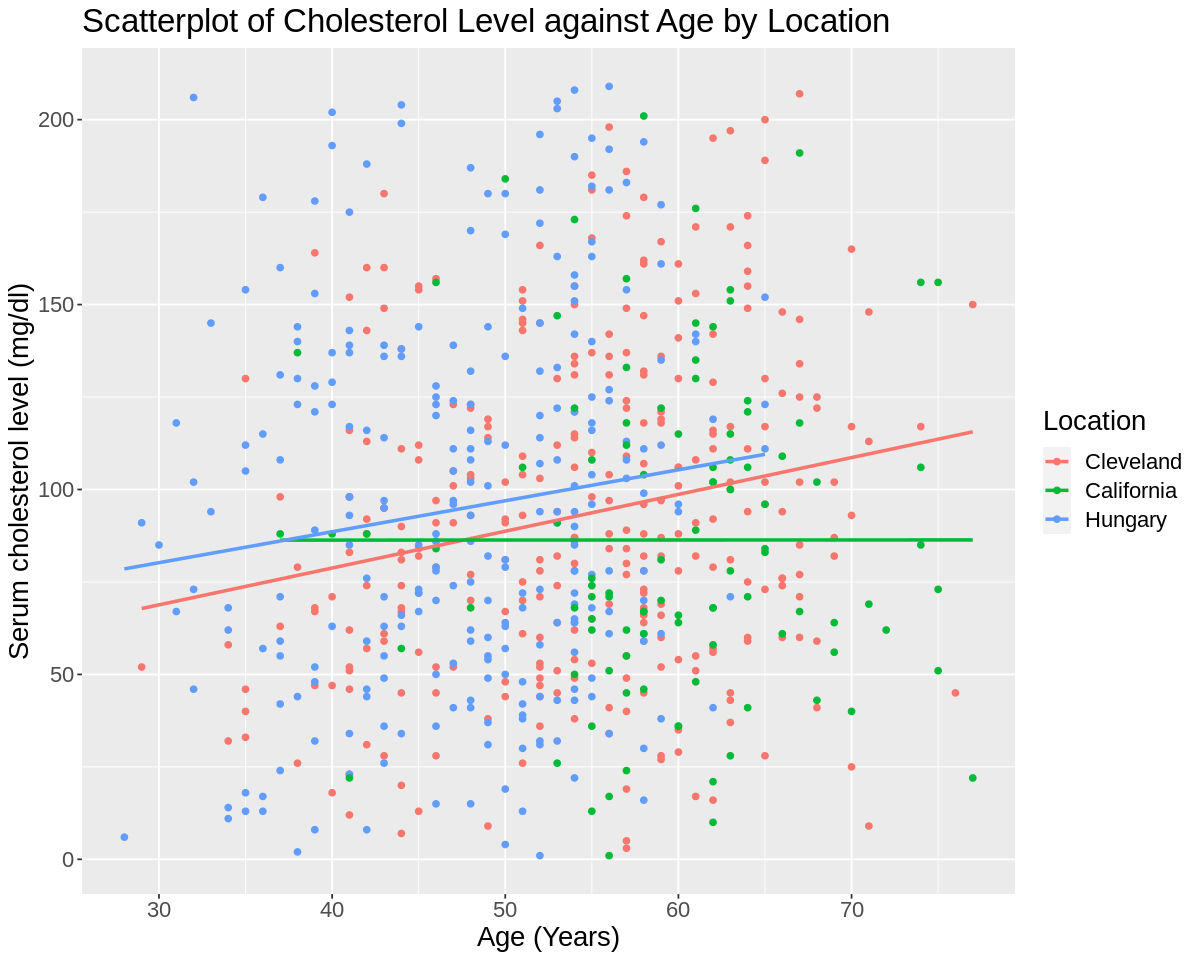

In [28]:
options(repr.plot.width = 10, repr.plot.height = 8)

heart_MLR_add_inter <- lm(chol ~ age * location, data = total_heart) 
heart_MLR_add_inter

total_heart$pred_MLR_add_inter <- predict(heart_MLR_add_inter) # Using predict() to create estimated regression lines.

heart_MLR_add_inter_plot <- ggplot(total_heart, aes(
  x = age,
  y = chol,
  color = location
)) +
  geom_point() +
  geom_line(aes(y = pred_MLR_add_inter), size = 1) +
  labs(
    title = "Scatterplot of Cholesterol Level against Age by Location",
    x = "Age (Years)",
    y = "Serum cholesterol level (mg/dl)"
  ) +
  theme(
    text = element_text(size = 16.5),
    # plot.title = element_text(face = "bold"),
    # axis.title = element_text(face = "bold"),
    # legend.title = element_text(face = "bold"),
  ) +
  labs(color = "Location")
heart_MLR_add_inter_plot

### 2.4. Data on overall population
The data below consists of summary data for the overall population: 
- `total_heart_pop_data`: For each location, the mean (`heart_chol_mean`), standard deviation (`heart_chol_sd`), and median (`heart_chol_median`) of cholesterol level values, mean (`heart_age_mean`), standard deviation (`heart_age_sd`), and median (`heart_age_median`) of ages, and quantity (`n`) of patients are measured.

In [29]:
# Count number of each combination of year and location
countPatients <- total_heart %>% 
    group_by(location) %>%
    tally() 

# Obtaining point estimates for each combination of location and year
total_heart_pop_data <- total_heart %>% 
    # filter(year != 2014) %>% 
    group_by(location) %>% 
    summarize(
        heart_chol_mean = mean(chol), 
        heart_chol_sd = sd(chol), 
        heart_chol_median = median(chol), 
        heart_age_mean = mean(age), 
        heart_age_sd = sd(age), 
        heart_age_median = median(age)
    ) %>% 
    inner_join(countPatients) 
total_heart_pop_data

Joining with `by = join_by(location)`


location   heart_chol_mean heart_chol_sd heart_chol_median heart_age_mean
1 Cleveland  93.14191        44.43490      89                54.43894      
2 California 86.34314        43.69981      77                59.63725      
3 Hungary    95.07063        50.82042      91                47.75093      
  heart_age_sd heart_age_median n  
1 9.038662     56               303
2 7.968737     60               102
3 7.806023     49               269

## References
- Janosi, A., Steinbrunn, W., Pfisterer, M., &amp; Detrano, R. (1988, June 30). Heart disease. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease
- Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9
- Beckett, N., Nunes, M., & Bulpitt, C. (2000). Is it advantageous to lower cholesterol in the elderly hypertensive?. Cardiovascular drugs and therapy, 14(4), 397–405. https://doi.org/10.1023/a:1007812232328